# Experimenting with LightGBM

Data: NBA Rookie Longevity<br>
Source: https://data.world/exercises/logistic-regression-exercise-1<br>
Question: Will each rookie last five years in the league?

In [1]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, accuracy_score, 
    roc_auc_score, auc, roc_curve
)
from sklearn.model_selection import train_test_split

In [2]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

In [3]:
base_path = "/Users/aaronjones/Documents/github/classification-exercises/light_gbm/"

df = pd.read_csv(base_path+"nba_logreg.csv", header=0)

In [4]:
print(df.shape)
print(df.columns)

(1340, 21)
Index(['Name', 'GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P Made', '3PA',
       '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
       'TOV', 'TARGET_5Yrs'],
      dtype='object')


In [5]:
df = (
    df
    .rename(columns={"FG%": "FGpct", "3P Made": "3Pmade", "3P%": "3Ppct", 
                     "TARGET_5Yrs": "target"})
    .drop(columns="Name")
    .dropna()
)

print(df.shape)
print(df.columns)

(1329, 20)
Index(['GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FGpct', '3Pmade', '3PA', '3Ppct',
       'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV',
       'target'],
      dtype='object')


#### Data Prep

In [6]:
X = df.drop(columns="target").to_numpy()
y = df.target.values

In [7]:
Xtrain, Xvalid, ytrain, yvalid = train_test_split(
    X, y, test_size=0.3, random_state=0, shuffle=True, stratify=y
)

In [8]:
target_vecs = {"all": df.target.values, "ytrain": ytrain, "ytest": yvalid}
for k in target_vecs.keys():
    tmp = target_vecs[k]
    unique, counts = np.unique(tmp, return_counts=True)
    percents = np.array([round(c / len(tmp), 4) for c in counts])
    output = np.asarray((unique, percents)).T
    print("Name: "+ k)
    print(output)

Name: all
[[0.     0.3785]
 [1.     0.6215]]
Name: ytrain
[[0.     0.3785]
 [1.     0.6215]]
Name: ytest
[[0.     0.3784]
 [1.     0.6216]]


#### Light GBM

In [9]:
dtrain = lgb.Dataset(Xtrain, label=ytrain)
dvalid = lgb.Dataset(Xvalid, label=yvalid, reference=dtrain)

In [10]:
param = {
    'objective': 'binary', 
    'metric': ['auc', 'binary_logloss', 'binary_error'],
    'learning_rate': 0.01,
    'max_depth': 3,
    'num_leaves': 5
}

evals_result = {}

gbm = lgb.train(
    param,
    dtrain,
    num_boost_round=150,
    valid_sets=[dtrain, dvalid],
    feature_name=[
        'GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FGpct', '3Pmade', '3PA', '3Ppct', 
        'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV'
    ], 
    evals_result=evals_result,
    verbose_eval=10
)

[10]	training's auc: 0.75664	training's binary_logloss: 0.647574	training's binary_error: 0.378495	valid_1's auc: 0.745714	valid_1's binary_logloss: 0.649256	valid_1's binary_error: 0.378446
[20]	training's auc: 0.77068	training's binary_logloss: 0.634292	training's binary_error: 0.378495	valid_1's auc: 0.758398	valid_1's binary_logloss: 0.637784	valid_1's binary_error: 0.378446
[30]	training's auc: 0.773293	training's binary_logloss: 0.622867	training's binary_error: 0.378495	valid_1's auc: 0.761402	valid_1's binary_logloss: 0.628485	valid_1's binary_error: 0.378446
[40]	training's auc: 0.777834	training's binary_logloss: 0.612772	training's binary_error: 0.378495	valid_1's auc: 0.761069	valid_1's binary_logloss: 0.620297	valid_1's binary_error: 0.378446
[50]	training's auc: 0.780051	training's binary_logloss: 0.60394	training's binary_error: 0.368817	valid_1's auc: 0.761843	valid_1's binary_logloss: 0.613339	valid_1's binary_error: 0.370927
[60]	training's auc: 0.782516	training's bi

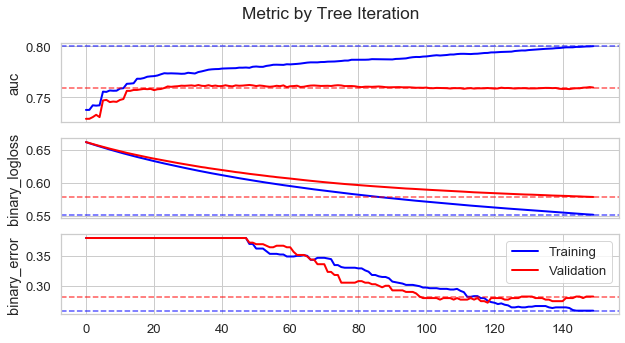

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 5))

for idx, score in enumerate(param["metric"]):
    
    #
    tmp_train = evals_result["training"][score]
    tmp_valid = evals_result["valid_1"][score]
    #
    axes[idx].plot(tmp_train, c="blue", lw=2, label="Training")
    axes[idx].plot(tmp_valid, c="red", lw=2, label="Validation")
    #
    axes[idx].axhline(tmp_train[-1], c="blue", lw=1.5, ls="--", alpha=0.65)
    axes[idx].axhline(tmp_valid[-1], c="red", lw=1.5, ls="--", alpha=0.65)
    #
    axes[idx].set_ylabel(score)
    
    if idx != 2:
        
        #
        axes[idx].xaxis.set_major_formatter(plt.NullFormatter())

plt.suptitle("Metric by Tree Iteration")
plt.legend()
plt.show()

In [12]:
ytrain_prob = gbm.predict(Xtrain)
yvalid_prob = gbm.predict(Xvalid)

In [13]:
thresholds = np.linspace(0.05, 0.95, 19)
logistic_arrays = []
logistic_scores = []

for t in thresholds:
    tmp_class = [1. if p >= t else 0. for p in ytrain_prob]
    logistic_arrays.append(tmp_class) 
    logistic_scores.append(roc_auc_score(ytrain, tmp_class))

In [14]:
index = np.argmax(logistic_scores)
optimal_threshold = thresholds[index]

print("Probability Threshold: " + str(optimal_threshold))

Probability Threshold: 0.6


In [15]:
ytrain_class = logistic_arrays[index]
yvalid_class = [1. if p >= optimal_threshold else 0. for p in yvalid_prob]

print("""
------Training Metrics------\n
Confusion Matrix:\n{cntrain}
Accuracy:{acctrain}
ROC AUC Score:{auctrain}\n
------Validation Metrics------\n
Confusion Matrix:\n{cnvalid}
Accuracy:{accvalid}
ROC AUC Score:{aucvalid}""".format(
    cntrain=confusion_matrix(ytrain, ytrain_class),
    acctrain=round(accuracy_score(ytrain, ytrain_class), 3),
    auctrain=round(roc_auc_score(ytrain, ytrain_class), 3),
    cnvalid=confusion_matrix(yvalid, yvalid_class),
    accvalid=round(accuracy_score(yvalid, yvalid_class), 3),
    aucvalid=round(roc_auc_score(yvalid, yvalid_class), 3)
))


------Training Metrics------

Confusion Matrix:
[[269  83]
 [180 398]]
Accuracy:0.717
ROC AUC Score:0.726

------Validation Metrics------

Confusion Matrix:
[[107  44]
 [ 80 168]]
Accuracy:0.689
ROC AUC Score:0.693


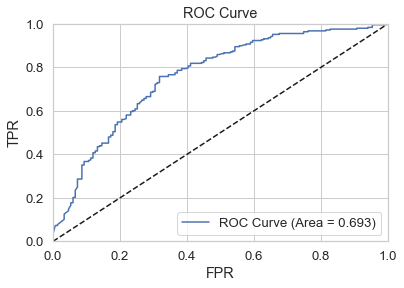

In [16]:
fpr, tpr, thresholds = roc_curve(yvalid, yvalid_prob, pos_label=1.)
auc_score = round(roc_auc_score(yvalid, yvalid_class), 3)

plt.plot(fpr, tpr, label="ROC Curve (Area = %0.3f)" % auc_score)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend(loc="lower right")